In [ ]:
%load_ext autoreload
%autoreload 2

# Text: Training Core

> The `text.training.core` module contains the core bits required to train text/NLP models with fast.ai

In [ ]:
# |default_exp text.training.core
# |default_cls_lvl 3

In [ ]:
# |export
from __future__ import annotations

import gc, importlib, sys, traceback

from accelerate.logging import get_logger
from dataclasses import dataclass
from dotenv import load_dotenv
from fastai.callback.all import *
from fastai.imports import *
from fastai.learner import *
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import (
    AutoConfig,
    AutoTokenizer,
    PretrainedConfig,
    PreTrainedTokenizerBase,
    PreTrainedModel,
    AutoModelForSequenceClassification,
)
from transformers import logging as hf_logging

from blurr.utils import clean_memory, get_hf_objects, set_seed, PreCalculatedLoss

In [ ]:
# |hide
import pdb
from fastai.metrics import accuracy, F1Score, accuracy_multi, F1ScoreMulti
from fastai.losses import BaseLoss, BCEWithLogitsLossFlat, CrossEntropyLossFlat
from fastai.data.transforms import DataLoader, DataLoaders, Datasets
from fastai.optimizer import Adam, OptimWrapper, params
from datasets import concatenate_datasets, load_dataset, Value
from fastai.data.block import MultiCategoryBlock, CategoryBlock, ColReader, ColSplitter, DataBlock, ItemGetter, RandomSplitter, FuncSplitter
from fastai.losses import BaseLoss, BCEWithLogitsLossFlat, CrossEntropyLossFlat
from fastai.text.data import SortedDL
from fastcore.test import *
import nbdev

from blurr.utils import (
    print_versions,
    set_seed,
    PreCalculatedLoss,
    PreCalculatedCrossEntropyLoss,
    PreCalculatedBCELoss,
    PreCalculatedMSELoss,
)
from blurr.text.data.core import *

In [ ]:
# |export
# silence all the HF warnings and load environment variables
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()
logger = get_logger(__name__)

load_dotenv()

False

In [ ]:
# |hide
# |notest
torch.cuda.set_device(0)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: NVIDIA GeForce RTX 3090


In [ ]:
# | echo: false
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.13.1
fastai: 2.7.11
transformers: 4.26.1


## Setup

We'll use a subset of `imdb` to demonstrate how to configure your BLURR for sequence classification tasks. **BLURR** is designed to work with Hugging Face `Dataset` and/or pandas `DataFrame` objects

### Multiclass

In [ ]:
imdb_dsd = load_dataset("imdb", split=["train", "test"])

# build HF `Dataset` objects
train_ds = imdb_dsd[0].add_column("is_valid", [False] * len(imdb_dsd[0])).shuffle().select(range(1000))
valid_ds = imdb_dsd[1].add_column("is_valid", [True] * len(imdb_dsd[1])).shuffle().select(range(200))
imdb_ds = concatenate_datasets([train_ds, valid_ds])

# build a `DataFrame` representation as well
imdb_df = pd.DataFrame(imdb_ds)

print(len(train_ds), len(valid_ds))
print(len(imdb_df[imdb_df["is_valid"] == False]), len(imdb_df[imdb_df["is_valid"] == True]))
imdb_df.head()

Found cached dataset imdb (/home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/2 [00:00<?, ?it/s]

1000 200
1000 200


,text,label,is_valid
0,"""One shot, one kill, no exceptions."" A must see if you are into marines or snipers. two big thumbs up! Great overall storyline, great camera work, good drama, action, details, and more. Pretty close to the real thing. But this isn't a film to breakdown and pick out the editing faults. this is to sit back and have a good 99 mins. The plot has some depth but this movie isn't really about making you think. its about enjoying the sniper lifestyle and action. sniper 2 and 3 are pretty good follow ups but the first is still the best overall movie. Tom Berenger does a great job playing his charac...",1,False
1,"I was gifted with this movie as it had such a great premise, the friendship of three women bespoiled by one falling in love with a younger man.<br /><br />Intriguing.<br /><br />NOT! I hasten to add. These women are all drawn in extreme caricature, not very supportive of one another and conspiring and contriving to bring each other down.<br /><br />Anna Chancellor and Imelda Staunton could do no wrong in my book prior to seeing this, but here they are handed a dismal script and told to balance the action between slapstick and screwball, which doesn't work too well when the women are all we...",0,False
2,"I wondered why John Wood was not playing Dr. Falken until I watched the film. BAD plot, bad science, bad acting and overall a bad film. Please don't watch this film. Rent the original ""War Games"" if you are feeling nostalgic.<br /><br />I didn't like the bending of the plot to beat-the-terrorist-threat idea either. In the first film W.O.P.R was built because Russia had 1000s of warheads pointed at the U.S.A. In this film the idea behind the computer was to kill terrorist in training before they are a threat. Politics aside, one of the good thing about the first film was the highlighting th...",0,False
3,"Director Jonathan Lynn has made some underrated comedies in the past, like 'Greedy' and 'Clue'. This isn't one of them. More akin to a 'Police Academy' film than its inspiration, it stars Steve Martin in the old Phil Silvers role as an army sergeant forever pulling scams under the nose of his superiors. But the idyllic life of Bilko and his lazy platoon looks shaky when an old enemy visits the base determined to catch Bilko in the act. Nothing much happens, really. It's all quite dull. It's not very funny. Martin, Dan Aykroyd and Phil Hartman squeeze a couple of laughs out through sheer ef...",0,False
4,"Yet another colourful excuse for men in rubber suits to wrestle with each other. This time around, time travellers from the future arrive in 1992 and recruit a few people to go back with them to 1944 and prevent the creation of Godzilla, thus saving a future Japan from destruction. But having accomplished this task, the time travellers are revealed to be a bunch of double crossers whose own creature goes on the rampage, and with no Godzilla to stop it Eek! It all sounds very silly, and it probably is, but the plot is surprisingly decent and the final battle looks pretty good too. Unfortun...",0,False


In [ ]:
labels = imdb_dsd[0].features["label"].names
labels

['neg', 'pos']

### Multilabel

In [ ]:
civil_dsd = load_dataset("civil_comments", split=["train", "validation"])

# round the floats
civil_labels = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack", "sexual_explicit"]


def round_targs(example):
    for lbl in civil_labels:
        example[lbl] = np.round(example[lbl])
    return example


# convert floats to ints
def fix_dtypes(ds):
    new_features = ds.features.copy()
    for lbl in civil_labels:
        new_features[lbl] = Value("int32")
    return ds.cast(new_features)


# build HF `Dataset` objects
civil_train_ds = civil_dsd[0].add_column("is_valid", [False] * len(civil_dsd[0])).shuffle().select(range(1000))
civil_train_ds = civil_train_ds.map(round_targs)
civil_train_ds = fix_dtypes(civil_train_ds)

civil_valid_ds = civil_dsd[1].add_column("is_valid", [True] * len(civil_dsd[1])).shuffle().select(range(200))
civil_valid_ds = civil_valid_ds.map(round_targs)
civil_valid_ds = fix_dtypes(civil_valid_ds)

civil_ds = concatenate_datasets([civil_train_ds, civil_valid_ds])

# build a `DataFrame` representation as well
civil_df = pd.DataFrame(civil_ds)

print(len(civil_train_ds), len(civil_valid_ds))
print(len(civil_df[civil_df["is_valid"] == False]), len(civil_df[civil_df["is_valid"] == True]))
civil_df.head()

Found cached dataset civil_comments (/home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab)


  0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

1000 200
1000 200


,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,is_valid
0,'how trump and his administration will react to it?'...they will react the way this narcissistic reflex with small hands and orange face has always reacted....bombs away!,0,0,0,0,0,0,0,False
1,"By ""reproductive rights for American women"" you of course mean their ""right"" to not reproduce -- even after having conceived -- by killing their child, thereby denying all inalienable human rights to that new human being whom their own choices and actions created. When we think about the wrongness of human slavery, abortion is even more heinous as it not only takes away all rights, but life itself. Being a woman has it burdens, but all should agree being dead at the hands of your own mother is far, far worse.",0,0,0,0,0,0,0,False
2,"Chairman Mao was never named as Time Magazine, Person of the Year.",0,0,0,0,0,0,0,False
3,This is the best article today in this trashy newspaper. So tired of Caldwell and Ige boasting because they put 30 more people into housing when they are sweeping people around like my yardman does with leaves with his blower.,0,0,0,0,0,0,0,False
4,"You're right. Fire a missile north, and it flies over China and Russia. Fire a missile east, and it flies over Japan. Fire a missile south, and it flies over South Korea. Fire a missile west, and it flies over China.\n\nYou might be able to avoid an overflight of any of these countries if you fire a missile south south west towards the Philippines. And only if you launched it from somewhere along the west coast of North Korea.",0,0,0,0,0,0,0,False


## Base API

Base plitters for defining paramater groups, model wrapper, and model callback

### `blurr_splitter`s -

In [ ]:
# |export
def blurr_params(modules: Module | list[Module]):
    "Like fast.ai's `params()` method, this method returns all parameters of `m` but also works with lists of modules"
    if not is_listy(modules):
        modules = [modules]
    return [p for m in modules for p in m.parameters()]

In [ ]:
nbdev.show_doc(blurr_params, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/training/core.py#L34){target="_blank" style="float:right; font-size:smaller"}

### blurr_params

>      blurr_params
>                    (modules:fastai.torch_core.Module|list[fastai.torch_core.Mo
>                    dule])

Like fast.ai's `params()` method, this method returns all parameters of `m` but also works with lists of modules

In [ ]:
# |export
def blurr_splitter(m: Module):
    """Splits the Hugging Face model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]

    groups = L([m for m_name, m in list(top_module.named_children())])
    groups += L([m for m_name, m in root_modules[1:]])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/training/core.py#L41){target="_blank" style="float:right; font-size:smaller"}

### blurr_splitter

>      blurr_splitter (m:fastai.torch_core.Module)

Splits the Hugging Face model based on various model architecture conventions

In [ ]:
# |export
def blurr_splitter_on_head(m: Module):
    """Creates two layers groups: One for the backbone and one for the pooler/classification head"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    backbone_module_name, backbone_module = root_modules[0]

    groups = L(backbone_module)
    groups.append(L([m for m_name, m in root_modules[1:]]))

    return groups.map(blurr_params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter_on_head, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/training/core.py#L53){target="_blank" style="float:right; font-size:smaller"}

### blurr_splitter_on_head

>      blurr_splitter_on_head (m:fastai.torch_core.Module)

Creates two layers groups: One for the backbone and one for the pooler/classification head

### `BaseModelWrapper` -

In [ ]:
# |export
class BaseModelWrapper(Module):
    def __init__(
        self,
        # Your Hugging Face model
        hf_model: PreTrainedModel,
        # If True, hidden_states will be returned and accessed from Learner
        output_hidden_states: bool = False,
        # If True, attentions will be returned and accessed from Learner
        output_attentions: bool = False,
        # Any additional keyword arguments you want passed into your models forward method
        hf_model_kwargs={},
    ):
        super().__init__()

        store_attr()
        self.hf_model = hf_model.cuda() if torch.cuda.is_available() else hf_model
        self.hf_model_fwd_args = list(inspect.signature(self.hf_model.forward).parameters.keys())

    def forward(self, x):
        for k in list(x):
            if k not in self.hf_model_fwd_args:
                del x[k]

        return self.hf_model(
            **x,
            output_hidden_states=self.output_hidden_states,
            output_attentions=self.output_attentions,
            return_dict=True,
            **self.hf_model_kwargs,
        )

Note that `BaseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

### `BaseModelCallback` -

In [ ]:
# |export
class BaseModelCallback(Callback):
    def __init__(
        self,
        # Additional keyword arguments passed to `BaseModelWrapper`
        base_model_wrapper_kwargs: dict = {},
    ):
        self.base_model_wrapper_kwargs = base_model_wrapper_kwargs

    def after_create(self):
        if isinstance(self.learn.model, PreTrainedModel):
            self.learn.model = BaseModelWrapper(self.learn.model, **self.base_model_wrapper_kwargs)

    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()

We use a `Callback` for handling the [`ModelOutput`](https://huggingface.co/transformers/main_classes/output.html#transformers.file_utils.ModelOutput) returned by Hugging Face transformers. It allows us to associate anything we want from that object to our `Learner`.

**Note** that your `Learner`'s loss will be set for you only if the Hugging Face model returns one *and* you are using the `PreCalculatedLoss` loss function.  

Also note that anything else you asked the model to return (for example, last hidden state, etc..) will be available for you via the `blurr_model_outputs` property attached to your `Learner`. For example, assuming you are using BERT for a classification task ... if you have told your `BaseModelWrapper` instance to return attentions, you'd be able to access them via `learn.blurr_model_outputs['attentions']`.

## Base API: Examples

This section demonstrates how you can use standard `Dataset` objects (PyTorch and Hugging Face) to build PyTorch `DataLoader` iterators and train your model using the fast.ai `Learner`. 

**Note** that most fast.ai specific features such as `DataLoaders.one_batch`, `Learner.show_summary`, `DataLoader.show_batch`, `Learner.show_results` are not available when using PyTorch.

### PyTorch

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", labels, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `torch.utils.data.Dataset`s

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['"One shot, one kill, no exceptions." A must see if you are into marines or snipers. two big thumbs up! Great overall storyline, great camera work, good drama, action, details, and more. Pretty close to the real thing. But this isn\'t a film to breakdown and pick out the editing faults. this is to sit back and have a good 99 mins. The plot has some depth but this movie isn\'t really about making you think. its about enjoying the sniper lifestyle and action. sniper 2 and 3 are pretty good follow ups but the first is still the best overall movie. Tom Berenger does a great job playing his character and showing the hidden side of the sniper life. the plain of dealing with all of the death. Must see for sniper fans.', "I was gifted with this movie as it had such a great premise, the friendship of three women bespoiled by one falling in love with a younger man.<br /><br />Intriguing.<br /><br />NOT! I hasten to add. These women are all drawn in 

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_valid_ds = valid_ds.map(tokenize_func, batched=True)
proc_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTextClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        return item


# build our PyTorch training and validation Datasets
pt_proc_train_ds = HFTextClassificationDataset(proc_train_ds, hf_tokenizer=hf_tokenizer)
pt_proc_valid_ds = HFTextClassificationDataset(proc_valid_ds, hf_tokenizer=hf_tokenizer)

##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=3.981071586167673e-07, steep=1.9054607491852948e-06, valley=0.00010964782268274575, slide=0.0004786300996784121)

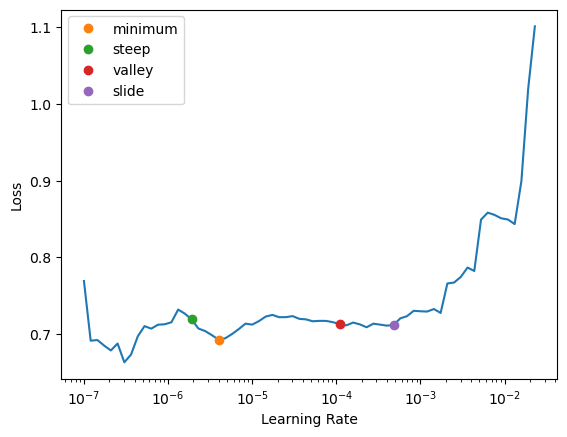

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.12542270123958588
valid_loss 0.12399120628833771
accuracy 0.9399999976158142


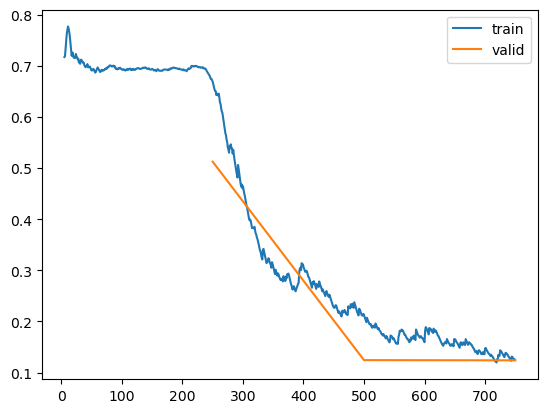

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_labels, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `torch.utils.data.Dataset`s

In [ ]:
print("Train|Validation examples: ", len(civil_train_ds), len(civil_valid_ds))

print(civil_train_ds[:2])
print("")
print(civil_train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ["'how trump and his administration will react to it?'...they will react the way this narcissistic reflex with small hands and orange face has always reacted....bombs away!", 'By "reproductive rights for American women" you of course mean their "right" to not reproduce -- even after having conceived -- by killing their child, thereby denying all inalienable human rights to that new human being whom their own choices and actions created. When we think about the wrongness of human slavery, abortion is even more heinous as it not only takes away all rights, but life itself. Being a woman has it burdens, but all should agree being dead at the hands of your own mother is far, far worse.'], 'toxicity': [0, 0], 'severe_toxicity': [0, 0], 'obscene': [0, 0], 'threat': [0, 0], 'insult': [0, 0], 'identity_attack': [0, 0], 'sexual_explicit': [0, 0], 'is_valid': [False, False]}

["'how trump and his administration will react to it?'...they will react th

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_civil_train_ds = civil_train_ds.map(tokenize_func, batched=True)
proc_civil_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + civil_labels)

proc_civil_valid_ds = civil_valid_ds.map(tokenize_func, batched=True)
proc_civil_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + civil_labels)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTextMultilabelClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer, labels):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer
        self.labels = labels

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        item["label"] = [item[lbl] for lbl in self.labels]
        return item


# build our PyTorch training and validation Datasets
pt_proc_civil_train_ds = HFTextMultilabelClassificationDataset(proc_civil_train_ds, hf_tokenizer=hf_tokenizer, labels=civil_labels)
pt_proc_civil_valid_ds = HFTextMultilabelClassificationDataset(proc_civil_valid_ds, hf_tokenizer=hf_tokenizer, labels=civil_labels)

##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_civil_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_civil_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=0.00036307806149125097, steep=0.02290867641568184, valley=7.585775892948732e-05, slide=0.0006918309954926372)

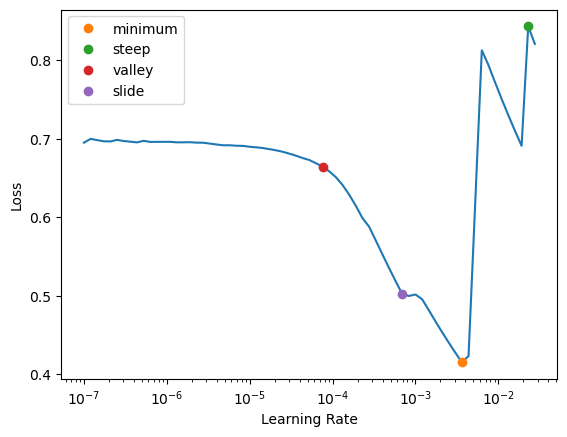

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.06155836209654808
valid_loss 0.05745584890246391
accuracy_multi 0.9864284992218018


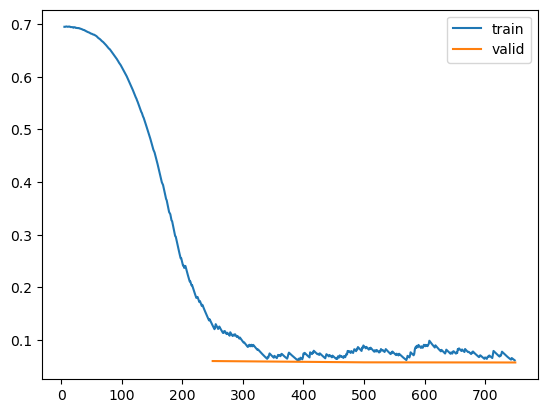

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Hugging Face

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", labels, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['"One shot, one kill, no exceptions." A must see if you are into marines or snipers. two big thumbs up! Great overall storyline, great camera work, good drama, action, details, and more. Pretty close to the real thing. But this isn\'t a film to breakdown and pick out the editing faults. this is to sit back and have a good 99 mins. The plot has some depth but this movie isn\'t really about making you think. its about enjoying the sniper lifestyle and action. sniper 2 and 3 are pretty good follow ups but the first is still the best overall movie. Tom Berenger does a great job playing his character and showing the hidden side of the sniper life. the plain of dealing with all of the death. Must see for sniper fans.', "I was gifted with this movie as it had such a great premise, the friendship of three women bespoiled by one falling in love with a younger man.<br /><br />Intriguing.<br /><br />NOT! I hasten to add. These women are all drawn in 

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_valid_ds = valid_ds.map(tokenize_func, batched=True)
proc_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

print(proc_train_ds)
print(proc_valid_ds)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-d200ed6e26ad9952.arrow


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})


##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=2.290867705596611e-05, steep=0.019054606556892395, valley=6.30957365501672e-05, slide=0.0014454397605732083)

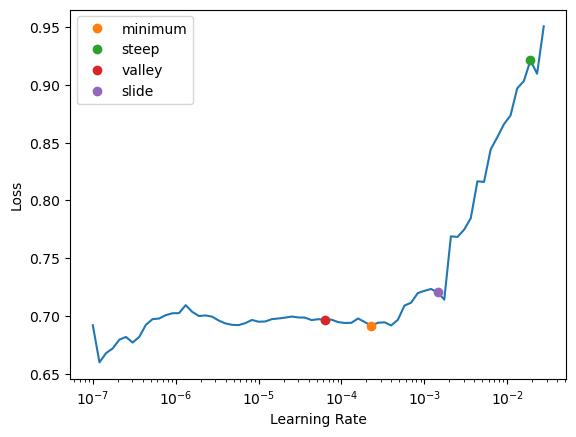

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.13723844289779663
valid_loss 0.13554267585277557
accuracy 0.9399999976158142


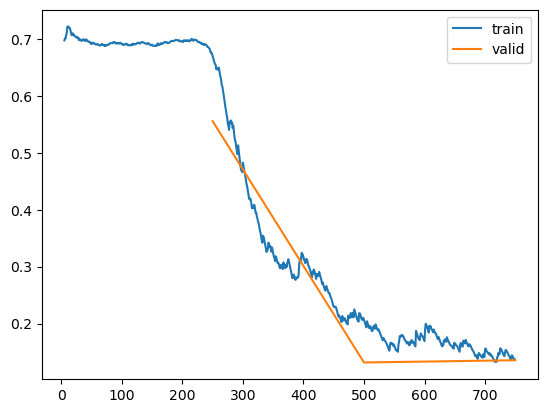

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_labels, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
print("Train|Validation examples: ", len(civil_train_ds), len(civil_valid_ds))

print(civil_train_ds[:2])
print("")
print(civil_train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ["'how trump and his administration will react to it?'...they will react the way this narcissistic reflex with small hands and orange face has always reacted....bombs away!", 'By "reproductive rights for American women" you of course mean their "right" to not reproduce -- even after having conceived -- by killing their child, thereby denying all inalienable human rights to that new human being whom their own choices and actions created. When we think about the wrongness of human slavery, abortion is even more heinous as it not only takes away all rights, but life itself. Being a woman has it burdens, but all should agree being dead at the hands of your own mother is far, far worse.'], 'toxicity': [0, 0], 'severe_toxicity': [0, 0], 'obscene': [0, 0], 'threat': [0, 0], 'insult': [0, 0], 'identity_attack': [0, 0], 'sexual_explicit': [0, 0], 'is_valid': [False, False]}

["'how trump and his administration will react to it?'...they will react th

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_labels], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_train_ds = civil_train_ds.map(tokenize_func, batched=True)
# proc_civil_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_civil_valid_ds = civil_valid_ds.map(tokenize_func, batched=True, batch_size=4)
# proc_civil_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

print(proc_civil_train_ds)
print(proc_civil_valid_ds)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 200
})


##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_civil_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_civil_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=0.00036307806149125097, steep=0.02290867641568184, valley=7.585775892948732e-05, slide=0.0006918309954926372)

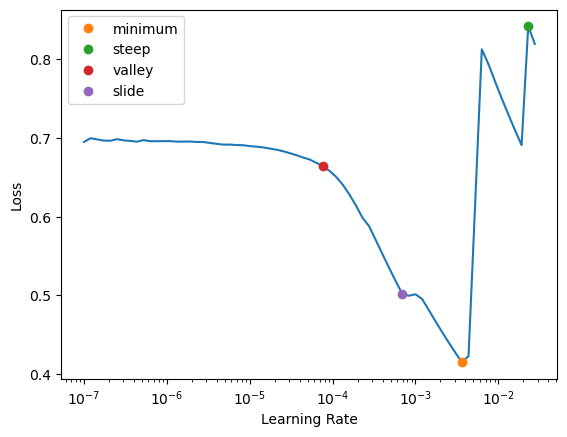

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.061560843139886856
valid_loss 0.05745392665266991
accuracy_multi 0.9864284992218018


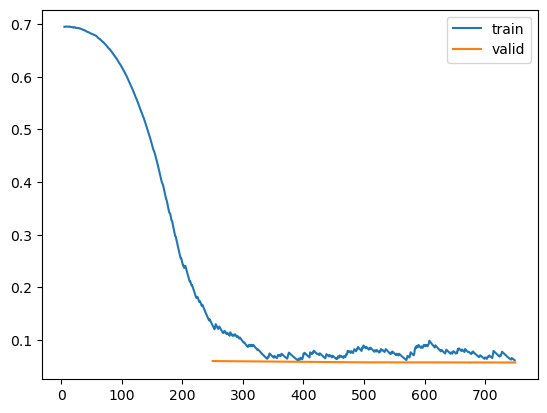

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Low-Level API

In this section, we include a custom `show_results()` method that will work with fast.ai's low-level and mid-level (think `DataBlock`) APIs.

### `show_results` -

In [ ]:
# |export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `TextInput` typed inputs
    x: TextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_results`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(learner.dls)
    hf_tokenizer = tfm.hf_tokenizer

    # if we've included our labels list, we'll use it to look up the value of our target(s)
    trg_labels = tfm.kwargs["labels"] if ("labels" in tfm.kwargs) else None

    res = L()
    n_inp = learner.dls.n_inp

    n_samples = min(max_n, learner.dls.bs)
    for idx in range(n_samples):
        pred = outs[idx]

        # add in the input text
        input_ids = x[idx]
        rets = [hf_tokenizer.decode(input_ids, skip_special_tokens=True)[:trunc_at]]

        # add in the targets
        sample = samples[idx] if samples is not None else None
        for item_idx, item in enumerate(sample[n_inp:]):
            label = y[item_idx] if y is not None else item

            if torch.is_tensor(label):
                label = list(label.numpy()) if len(label.size()) > 0 else label.item()

            if is_listy(label):
                trg = [trg_labels[int(idx)] for idx, val in enumerate(label) if (val == 1)] if trg_labels else label
            else:
                trg = trg_labels[int(item)] if trg_labels else item

            rets.append(trg)

        # add in the predictions
        for item in pred:
            if torch.is_tensor(item):
                item = list(item.numpy()) if len(item.size()) > 0 else item.item()

            if is_listy(item):
                p = [trg_labels[int(idx)] for idx, val in enumerate(item) if (val == 1)] if trg_labels else item
            else:
                p = trg_labels[int(item)] if trg_labels else item

            rets.append(p)

        res.append(tuplify(rets))

    cols = ["text"] + ["target" if (i == 0) else f"target_{i}" for i in range(len(res[0]) - n_inp * 2)]
    cols += ["prediction" if (i == 0) else f"prediction_{i}" for i in range(len(res[0]) - n_inp * 2)]
    display_df(pd.DataFrame(res, columns=cols)[:max_n])
    return ctxs

## Low-Level API: Examples

### Using fast.ai `Datasets` and `DataLoaders`

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", labels, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)
proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_imdb_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(imdb_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): 1


##### Step 3: `DataLoaders`

In [ ]:
data_collator = TextCollatorWithPadding(hf_tokenizer)
sort_func = partial(sorted_dl_func, hf_tokenizer=hf_tokenizer)

dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    dl_type=partial(SortedDL, sort_func=sort_func),
)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded while calling a Python object
# learn.dls.valid.show_batch()

In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 1596)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1596 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1596 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=1.0964781722577755e-07, steep=0.0012022644514217973, valley=4.786300905834651e-06, slide=0.0005754399462603033)

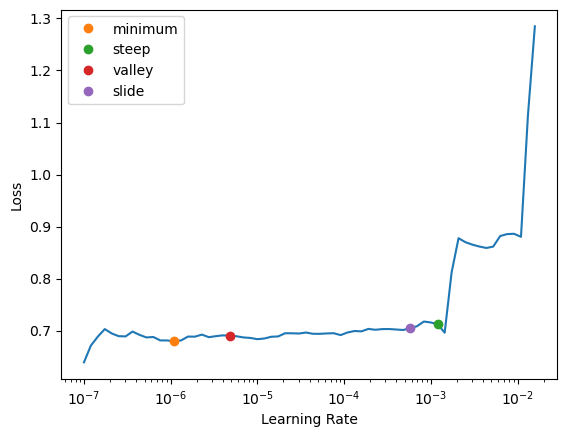

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.1284359246492386
valid_loss 0.13013596832752228
accuracy 0.925000011920929


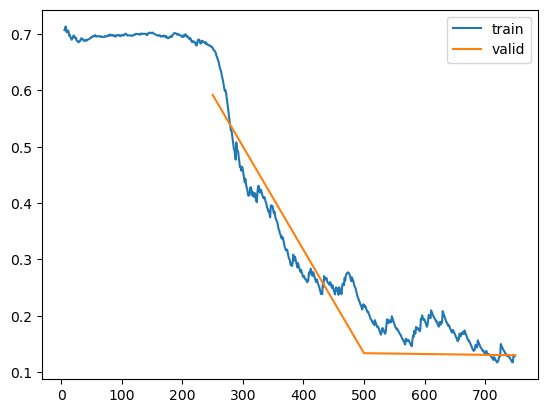

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded in __instancecheck__
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_labels, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_labels], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_ds = civil_ds.map(tokenize_func, batched=True)
proc_civil_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_civil_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(civil_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): tensor([1, 0, 0, 0, 1, 0, 0])


##### Step 3: `DataLoaders`

In [ ]:
data_collator = TextCollatorWithPadding(hf_tokenizer)
sort_func = partial(sorted_dl_func, hf_tokenizer=hf_tokenizer)
dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    dl_type=partial(SortedDL, sort_func=sort_func),
)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded while calling a Python object
# learn.dls.valid.show_batch()

In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 252)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 252 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 252 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.0013182567432522773, steep=0.0002754228771664202, valley=0.00019054606673307717, slide=0.001737800776027143)

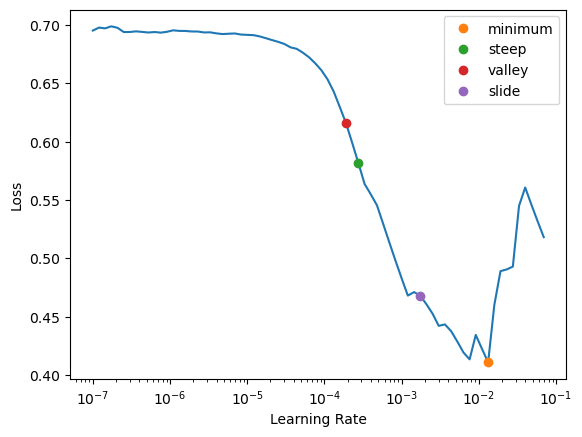

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.09593413025140762
valid_loss 0.05852627754211426
accuracy_multi 0.9864284992218018


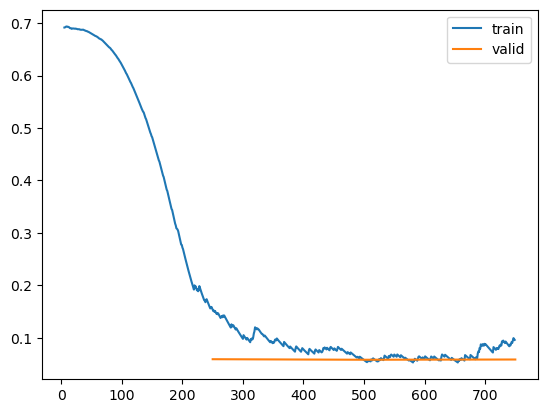

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded in __instancecheck__
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Using `BatchDecodeTransform` and `TextDataLoader`

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", labels, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Dataset`s

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)
# proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])


# define dataset splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)
splits = splitter(proc_imdb_ds)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=proc_imdb_ds, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-11a5b32274e1ea91.arrow


##### Step 3: `DataLoaders`

In [ ]:
label_names = train_ds.features["label"].names
label_names

['neg', 'pos']

In [ ]:
batch_size = 4

trn_dl = TextDataLoader(
    dsets.train,
    hf_tokenizer,
    batch_decode_kwargs={"labels": label_names},
    shuffle=True,
    batch_size=batch_size,
)

val_dl = TextDataLoader(
    dsets.valid,
    hf_tokenizer,
    batch_decode_kwargs={"labels": label_names},
    batch_size=batch_size * 2,
)

dls = DataLoaders(trn_dl, val_dl)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

,text,target
0,"I give this movie a ONE, for it is truly an awful movie. Sound track of the DVD is so bad, it actually hurts my ear. But the vision, no matter how disjointed, does show something really fancy in the Italian society. I will not go into detail what actually was so shocking, but the various incidents are absolutely abnormal. So for the kink value, i give it one.Otherwise, the video, photography, acting of the adults actors /actresses are simply substandard, a practical jock to people who love foreign movies.Roberto, the main character, has full spectrum of emotions but exaggerated to the point of being unbelievable.however, the children in the movie are mostly 3/4 years old, and they are genuine and the movie provides glimpse of the Italian life..",neg
1,"Alien Hunter: 5 out of 10: Is it me or does every movie that starts in Roswell, New Mexico suck. Take Alien mixed with The Thing, mixed with Contact, mixed with of all things On the Beach, The Andromeda Strain, the classroom scene from Raiders of the Lost Ark and a throw in a little Stargate to boot. <br /><br />Derivative doesn't even begin to describe this movie. Of course with nothing original plot wise they amp up the gore and sex right? Nope gore is a blink and you miss it affair and sex is all tease. (James Spader causally mentions he needs a shower and the delectable Leslie Stefanson asks to join him. he turns her down. AGGH!) <br /><br />In fact if a movie ever needed a shower scene to liven things up this is it. I mean if your going to have impossibly good-looking women in white b",neg


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_batch()` back
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"As a history of Custer, this insn't even close (Custer dies to help the indians? I am sure the other members of the 7th Cav weren't consulted in THAT decision.) But as a western, this is fun. Flynn looks, and acts, the part of the dashing cavalier. A",pos
1,I was lucky enough recently to see Ingrid Bergman's name attached to a film I had never seen (or even heard of) on AMC. What a stroke of luck.<br /><br />To marvel at her flawless and seamless performance isn't the only reason to stay up late and wat,pos


In [ ]:
# YES: Will work now that we're using fastai `TfmDL`s` and transforms
learn.summary()

BaseModelWrapper (Input shape: 4 x 562)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 562 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 562 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=2.7542287170945203e-07, steep=0.0063095735386013985, valley=9.120108734350652e-05, slide=0.0010000000474974513)

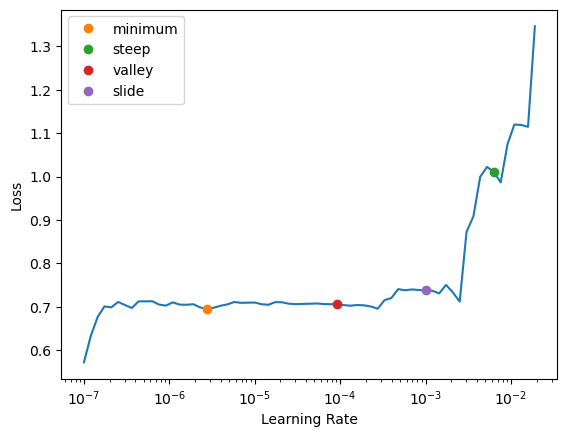

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.12851029634475708
valid_loss 0.12004075944423676
accuracy 0.949999988079071


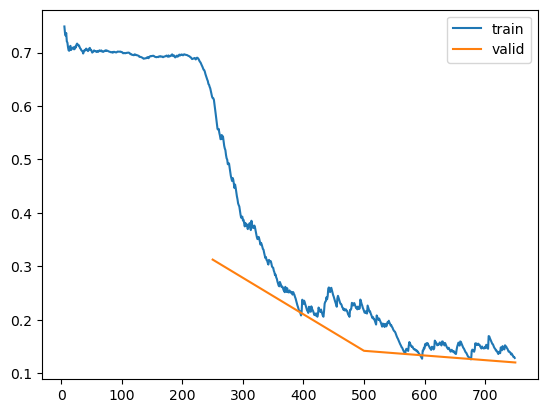

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_results()` back
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"well, i may be bias as i grew up watching a VHS copy of this film that is now ready to snap and have just spent the last couple of hours tracking down a DVD copy as a birthday pressie for my Dad. The film is so harmless and inoffensive it suits all ages.... much better than anything Disney ever made in my opinion (and i used to work in the Disney Store!!!). The characters are enjoyable and the award for best scene is a tie between the disrupted wedding (especially the musical talents of Swat, th",pos,pos
1,"An elite American military team which of course happens to include two good looking women and a guy who can't quite grasp teamwork, lots of bats, some terrorists, and a Spetznaz team that acts like the gang that can't shoot straight -- all thrown together in a jumbled plot with mediocre acting. This one has nothing much going for it. The characters are not compelling. Even the setting, which has great possibilities, looks like something out of the middle of rural Pennsylvania, not an exotic Bore",neg,neg


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_labels, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Dataset`s

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_labels], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_ds = civil_ds.map(tokenize_func, batched=True)
# proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])


# define dataset splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)
splits = splitter(proc_civil_ds)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=proc_civil_ds, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab/cache-ccaa4e6292693eb5.arrow


##### Step 3: `DataLoaders`

In [ ]:
batch_size = 4

trn_dl = TextDataLoader(
    dsets.train,
    hf_tokenizer,
    batch_decode_kwargs={"labels": civil_labels},
    shuffle=True,
    batch_size=batch_size,
)

val_dl = TextDataLoader(
    dsets.valid,
    hf_tokenizer,
    batch_decode_kwargs={"labels": civil_labels},
    batch_size=batch_size * 2,
)

dls = DataLoaders(trn_dl, val_dl)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=8)

,text,target
0,"Well, I can't speak to whether it's in homosexual porn....but I heard from a friend that it's been in straight porn movies since the late 1970s....",[]
1,"Everyone took it as a joke except partisan hair splitting liberals. Hence the ""except you..."" comment. On cue you respond with silly drivel about your seven year old. Let's clear this up. Do you really think Trump was serious? Really? I'm old enough to recognize sarcasm or humor. Are you?",[]
2,Said a Republican back when the party stood for something...,[]
3,"""This new investigation is a massive diversion to distract from the lack of Republican oversight of the Trump administration and the national security threat that Russia poses,"" Lol... the whole Trump-Russia investigation is a diversion from the crimes of Hillary and the the Obama administration. What a sad joke the Dem party has become...",[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_batch()` back
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,What if populism isn't the biggest menace? What if it's elitist arrogance and stupidity?,"[toxicity, insult]"
1,"""How about protect US against themselves? "" Canada has strong gun control. Look how well it worked in Quebec City. Condescending Canadians need to get their own house in order after the Quebec massacre","[toxicity, insult]"


In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `learn.summary()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 95)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 95 x 768        
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 95 x 3072       
Linear                          

##### Step 5: Train

SuggestedLRs(minimum=0.0019054606556892395, steep=0.03981071710586548, valley=0.00019054606673307717, slide=0.0010000000474974513)

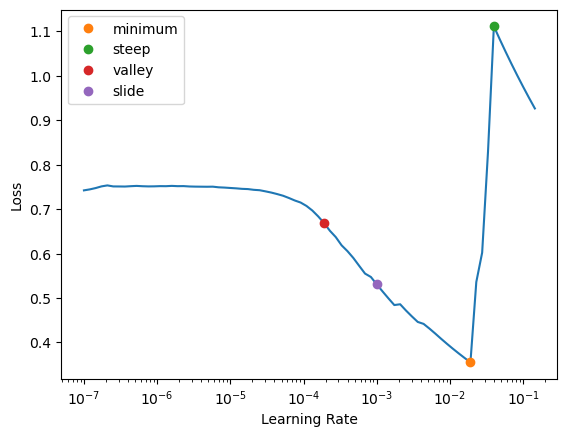

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.07223901152610779
valid_loss 0.056359000504016876
accuracy_multi 0.9864284992218018


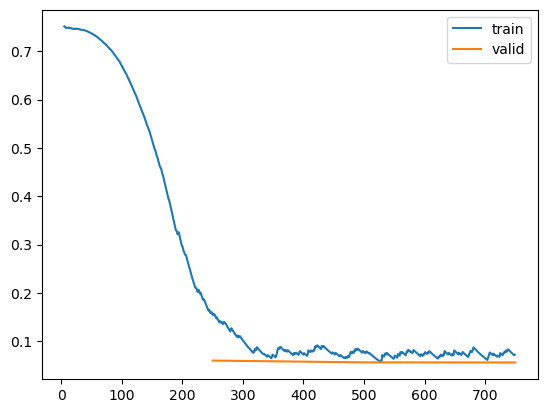

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_results()` back
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"That is harassment of me, nothing more, nothing less. The complete dialog with Motleycrew shows that I proved he was wrong in his characterization of the Clintons as thieves. Tell us what ""trend"" you have discovered? Do you consider your gratuitous and unearned summation of me to be civil? I do not.",[],[]
1,"How diversity wrecked it? In other words, because white people are so righteous? Purely racist statement--or alt-right as it's called now. Maybe you should move on, Dick.",[],[]


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Mid-Level API

Everything required to train transformers using the mid-level API is already there, so lets move straight to the examples

## Mid-Level API: Examples

### Pretokenized

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", labels, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
# define DataBlock splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)


# define how we want to build our targets
# note: we don't need to define how to build our inputs because we're using an HF `Dataset` in this example
def get_y(example):
    return example["label"]


# define the DataBlock
txt_block = TextBlock(
    hf_arch=hf_arch, hf_config=hf_config, hf_tokenizer=hf_tokenizer, hf_model=hf_model, batch_decode_kwargs={"labels": label_names}
)

blocks = (txt_block, CategoryBlock)
dblock = DataBlock(blocks=blocks, get_y=get_y, splitter=splitter)

##### Step 3: `DataLoaders`

In [ ]:
# tokenize the HF dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-11a5b32274e1ea91.arrow


In [ ]:
dls = dblock.dataloaders(proc_imdb_ds, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=250)

,text,target
0,"Berlin-born in 1942 Margarethe von Trotta was an actress and now she is a very important director and writer. She has been described, perhaps even unfairly caricatured, as a director whose commitment to bringing a woman's sensibility to the screen ou",pos
1,"One of the most important artistic movements in the history of cinema was without a doubt German expressionism, the highly atmospheric style of film-making developed during the 20s in Berlin. Classic movies like ""Das Cabinet Des Dr. Caligari."" (1920)",pos


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"As a history of Custer, this insn't even close (Custer dies to help the indians? I am sure the other members of the 7th Cav weren't consulted in THAT decision.) But as a western, this is fun. Flynn looks, and acts, the part of the dashing cavalier. A",pos
1,I was lucky enough recently to see Ingrid Bergman's name attached to a film I had never seen (or even heard of) on AMC. What a stroke of luck.<br /><br />To marvel at her flawless and seamless performance isn't the only reason to stay up late and wat,pos


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 1596)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1596 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1596 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=9.999999747378752e-07, steep=0.0012022644514217973, valley=5.248074739938602e-05, slide=0.0005754399462603033)

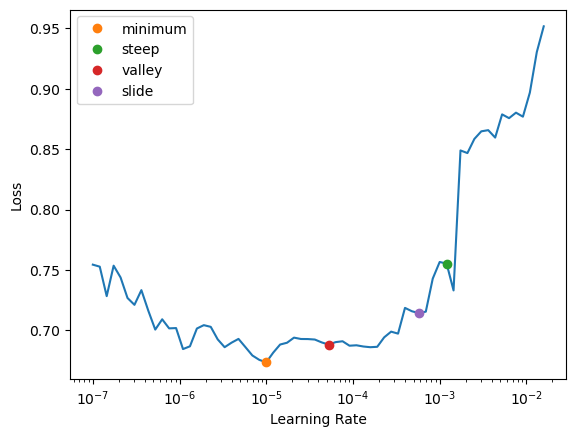

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.14098112285137177
valid_loss 0.14328014850616455
accuracy 0.9399999976158142


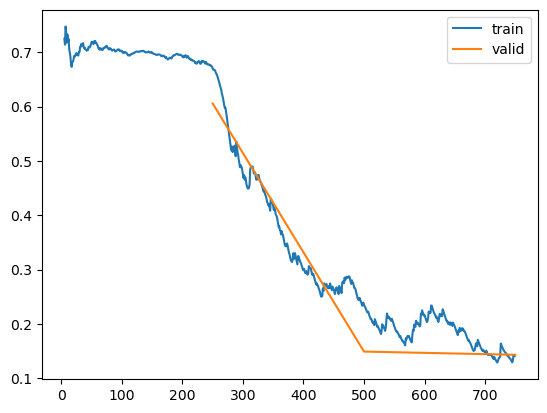

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"As a history of Custer, this insn't even close (Custer dies to help the indians? I am sure the other members of the 7th Cav weren't consulted in THAT decision.) But as a western, this is fun. Flynn looks, and acts, the part of the dashing cavalier. And the ""Garry Owen"" is always nice to hear!",pos,pos
1,"My father took me to see this film when it was released in 1976. I was but a child and it scared the crap out of me. So much so that I had to leave the theatre during a particularly claustrophobic tunnel scene as it was too intense for me!!! I went home to the safety of my family. I saw the film all the way through as I got older and thoroughly enjoyed it. Shame about the men in monster suits, though. If you overlook the cheapness of the production and delve deeper, you'll find an excellent perf",pos,pos


In [ ]:
learn.export("../models/test_text_core_mid_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_labels, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
# define DataBlock splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)


# define how we want to build our targets
# note: we don't need to define how to build our inputs because we're using an HF `Dataset` in this example
def get_y(example):
    return example["label"]


# define the DataBlock
txt_block = TextBlock(hf_arch=hf_arch, hf_config=hf_config, hf_tokenizer=hf_tokenizer, hf_model=hf_model)

blocks = (txt_block, MultiCategoryBlock(encoded=True, vocab=civil_labels))
dblock = DataBlock(blocks=blocks, get_y=get_y, splitter=splitter)

##### Step 3: `DataLoaders`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_labels], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_ds = civil_ds.map(tokenize_func, batched=True)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab/cache-ccaa4e6292693eb5.arrow


In [ ]:
dls = dblock.dataloaders(proc_civil_ds, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"""I never invest in fixed income"" All I can say is you are doing the right thing SFI...and don't ever change that rule!! Here's a rough analogy;your comment (though technically correct) is like saying ""you only take a loss (in equity) when you sell it""... As though the paper loss is irrelevant in the meantime. Another (hypothetical) analogy to attempt to set you right; Lets suppose we could somehow (physically) ""track"" actual individual bond certificates... 99% of them would be moving around...al",[]
1,"... the better. So I am taking advantage of the opportunity to make some additional principal payments because I like to budget, live within my means, and put some money aside. The result is that I can sleep soundly at night--even as Stephen Poloz threatens to drive interest rates up. It's not impossible to do this. All a person has to do is not go into the bank like a kid in a candy shop and take out the biggest mortgage the bank will give you. And make sure he or she pays off the credit cards",[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,What if populism isn't the biggest menace? What if it's elitist arrogance and stupidity?,"[toxicity, insult]"
1,"""How about protect US against themselves? "" Canada has strong gun control. Look how well it worked in Quebec City. Condescending Canadians need to get their own house in order after the Quebec massacre","[toxicity, insult]"


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 252)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 252 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 252 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.0009120108559727668, steep=0.05754399299621582, valley=0.00013182566908653826, slide=0.0005754399462603033)

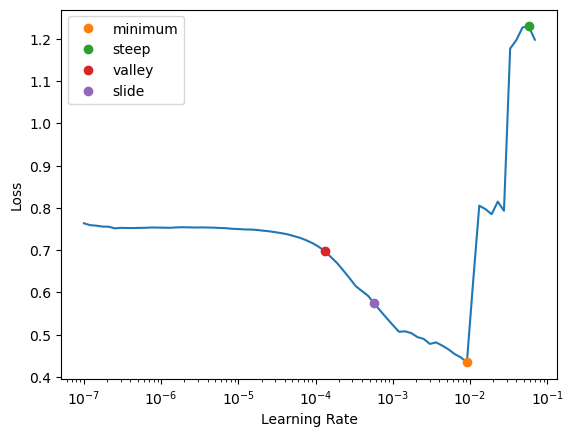

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.0927925631403923
valid_loss 0.05729822814464569
accuracy_multi 0.9864284992218018


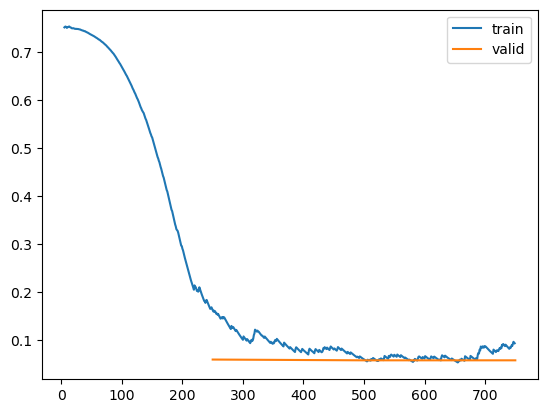

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,What if populism isn't the biggest menace? What if it's elitist arrogance and stupidity?,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",[]
1,"Comrade RTH, you mean the wall Trump promised he would make Mexico pay for? That wall?....lol....Dasvidaniya Comrade RTH #MRGA #itmfa...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",[]


In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([200, 7]), torch.Size([200, 7]), torch.Size([200]))

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Batch-Time Tokenization

#### Multiclass

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", labels, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tokenize_tfm = BatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model)

blocks = (
    TextBlock(tokenize_tfm=tokenize_tfm, batch_decode_kwargs={"labels": label_names}),
    CategoryBlock,
)
dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("text"),
    get_y=ColReader("label"),
    splitter=ColSplitter(),
)

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"Berlin-born in 1942 Margarethe von Trotta was an actress and now she is a very important director and writer. She has been described, perhaps even unfairly caricatured, as a director whose commitment to bringing a woman's sensibility to the screen outweighs her artistic strengths. ""Rosenstrasse,"" which has garnered mixed and even strange reviews (the New York Times article was one of the most negatively aggressive reviews I've ever read in that paper) is not a perfect film. It is a fine movie an",pos
1,"Already his first claim, that desires are always artificial, is totally fallacious.<br /><br />When a Jehovah Witness reject gets his own documentary on movies or anything for that matter - it's time for anyone to get their own. Although far, far more intelligent than, say, Paris Hilton (I know, not too difficult) Zizek's mouth spews just as much baloney as hers, just a different kind. He combines the worst from both his professional worlds: psychoanalysis and philosophy. Both fields are notori",neg


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"A film that tends to get buried under prejudice and preconception - It's a remake! Doris Day is in it! She sings! - Hitchcock's second crack at 'The Man Who Knew Too Much' is his most under-rated film, and arguably a fully fledged masterpiece in its",pos
1,"This is the dreary tale of the self absorbed affair between two unlikable people, one of whom is married to someone else. It ranks high on my list of most boring movies ever, and I'm a die hard romantic. My husband opted out after the first hour of i",neg


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 1596)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1596 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1596 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=1.0964781722577755e-07, steep=0.015848932787775993, valley=4.786300905834651e-06, slide=0.0005754399462603033)

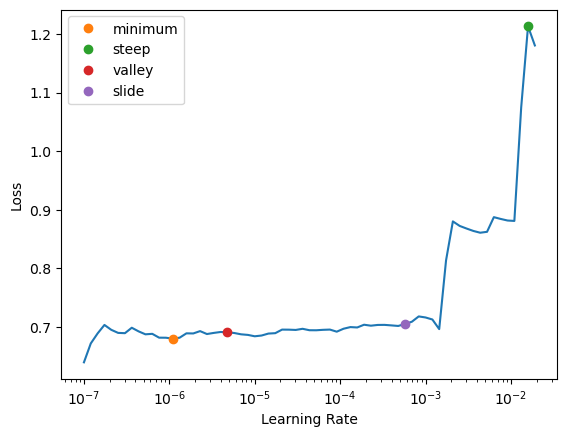

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.12092188000679016
valid_loss 0.12995146214962006
accuracy 0.9399999976158142


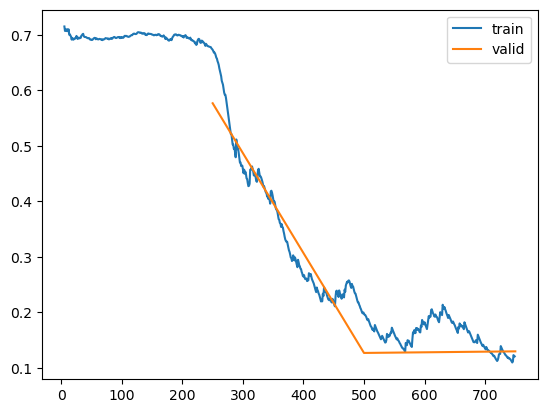

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"A film that tends to get buried under prejudice and preconception - It's a remake! Doris Day is in it! She sings! - Hitchcock's second crack at 'The Man Who Knew Too Much' is his most under-rated film, and arguably a fully fledged masterpiece in its own right.<br /><br />This is, in more ways than one, Doris Day's film. Not only does she give the finest performance of her career, more than holding her own against James Stewart, but the whole film is subtly structured around her character rather",pos,pos
1,"This is the dreary tale of the self absorbed affair between two unlikable people, one of whom is married to someone else. It ranks high on my list of most boring movies ever, and I'm a die hard romantic. My husband opted out after the first hour of its three, by which time little had transpired. The desert scenery is spectacular, with the endless sand and the sunshine on Katharine's golden hair. However, cinematography does not a brilliant film make, unless it's a National Geographic travelogue.",neg,neg


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_labels, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tokenize_tfm = BatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model)

blocks = (TextBlock(tokenize_tfm=tokenize_tfm), MultiCategoryBlock(encoded=True, vocab=civil_labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader("text"), get_y=ColReader(civil_labels), splitter=ColSplitter())

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(civil_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"""I never invest in fixed income"" All I can say is you are doing the right thing SFI...and don't ever change that rule!! Here's a rough analogy;your comment (though technically correct) is like saying ""you only take a loss (in equity) when you sell it""... As though the paper loss is irrelevant in the meantime. Another (hypothetical) analogy to attempt to set you right; Lets suppose we could somehow (physically) ""track"" actual individual bond certificates... 99% of them would be moving around...al",[]
1,"... the better. So I am taking advantage of the opportunity to make some additional principal payments because I like to budget, live within my means, and put some money aside. The result is that I can sleep soundly at night--even as Stephen Poloz threatens to drive interest rates up. It's not impossible to do this. All a person has to do is not go into the bank like a kid in a candy shop and take out the biggest mortgage the bank will give you. And make sure he or she pays off the credit cards",[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"On the bright side, there's less chance of public money in Douglas County getting embezzled to religious schools. Hey, I went to such a school myself, and its education was certainly formative for me, but my parents paid out-of-pocket for that distin",[]
1,"1) I use a screen name because this is a small island and I am not interested in being stalked, singled out, or harassed for my views. I also find that if you mention any personal detail on these boards, it is used to invalidate any opinion you may h",[]


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 252)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 252 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 252 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.001096478197723627, steep=0.03981071710586548, valley=0.00015848931798245758, slide=0.0005754399462603033)

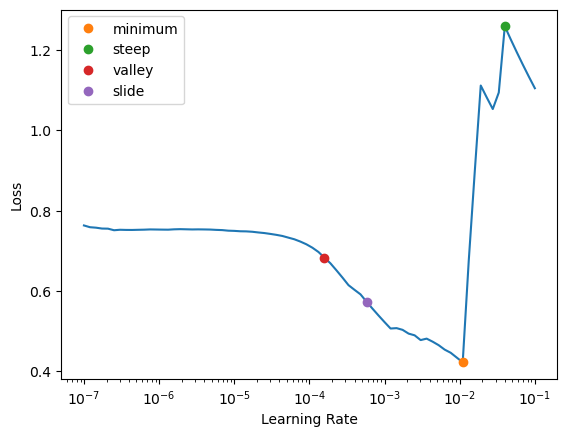

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.09278973191976547
valid_loss 0.05729692801833153
accuracy_multi 0.9864284992218018


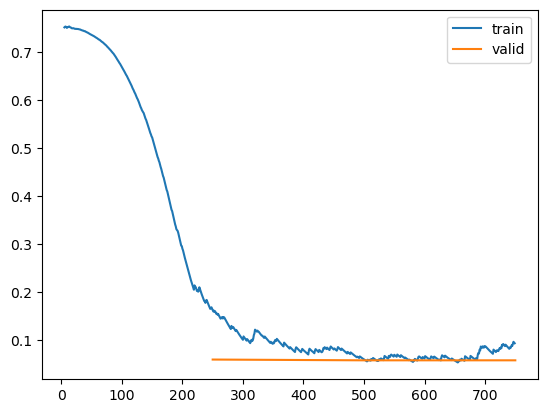

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"On the bright side, there's less chance of public money in Douglas County getting embezzled to religious schools. Hey, I went to such a school myself, and its education was certainly formative for me, but my parents paid out-of-pocket for that distinction even as their property taxes helped subsidize public education, because that's a social commitment, after all-- to all society, not just your family or religious community. Guys, fracking has such eye-bleedingly awful outcomes on hapless commun","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",[]
1,"1) I use a screen name because this is a small island and I am not interested in being stalked, singled out, or harassed for my views. I also find that if you mention any personal detail on these boards, it is used to invalidate any opinion you may have. So, no. 2) I think you need to look at your source again. The ""just $218 per family"" is a'myth' on the HART site that the Tax Foundation of Hawaii is ""busting."" From the page: ""$200, is the surcharge they can see. But there is a massive amount o","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",[]


In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([200, 7]), torch.Size([200, 7]), torch.Size([200]))

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Item-Time Tokenization

#### Multiclass

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", labels, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tfm = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer)
tfm.split_idx = 0

tfm2 = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer)
tfm2.split_idx = 1

blocks = (
    TextBlock(hf_arch=hf_arch, hf_config=hf_config, hf_tokenizer=hf_tokenizer, hf_model=hf_model, type_tfms=[tfm, tfm2]),
    CategoryBlock,
)

dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("text"),
    get_y=ColReader("label"),
    splitter=ColSplitter(),
)

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"Berlin-born in 1942 Margarethe von Trotta was an actress and now she is a very important director and writer. She has been described, perhaps even unfairly caricatured, as a director whose commitment to bringing a woman's sensibility to the screen outweighs her artistic strengths. ""Rosenstrasse,"" which has garnered mixed and even strange reviews (the New York Times article was one of the most negatively aggressive reviews I've ever read in that paper) is not a perfect film. It is a fine movie an",1
1,"Already his first claim, that desires are always artificial, is totally fallacious.<br /><br />When a Jehovah Witness reject gets his own documentary on movies or anything for that matter - it's time for anyone to get their own. Although far, far more intelligent than, say, Paris Hilton (I know, not too difficult) Zizek's mouth spews just as much baloney as hers, just a different kind. He combines the worst from both his professional worlds: psychoanalysis and philosophy. Both fields are notori",0


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"As a history of Custer, this insn't even close (Custer dies to help the indians? I am sure the other members of the 7th Cav weren't consulted in THAT decision.) But as a western, this is fun. Flynn looks, and acts, the part of the dashing cavalier. A",1
1,I was lucky enough recently to see Ingrid Bergman's name attached to a film I had never seen (or even heard of) on AMC. What a stroke of luck.<br /><br />To marvel at her flawless and seamless performance isn't the only reason to stay up late and wat,1


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 1596)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1596 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1596 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=1.0964781722577755e-07, steep=0.0012022644514217973, valley=4.786300905834651e-06, slide=0.0005754399462603033)

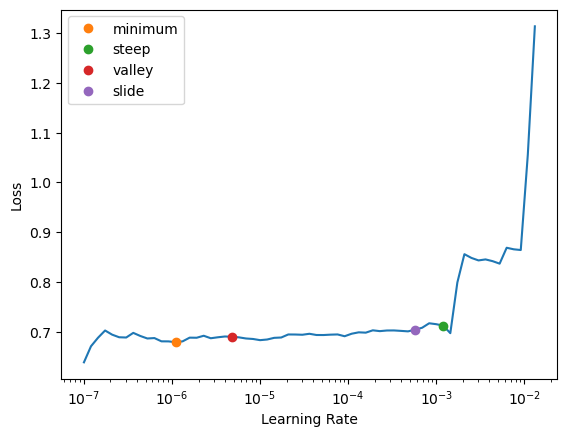

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.1202615424990654
valid_loss 0.12436993420124054
accuracy 0.9350000023841858


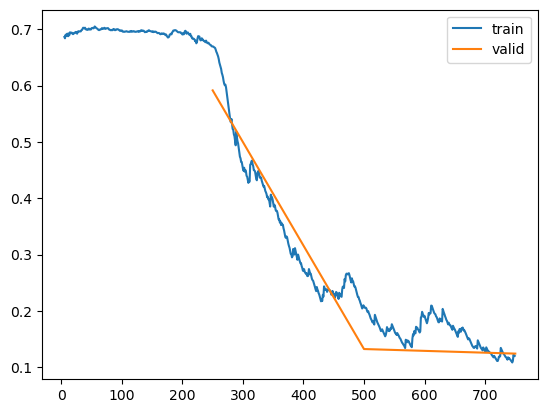

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"As a history of Custer, this insn't even close (Custer dies to help the indians? I am sure the other members of the 7th Cav weren't consulted in THAT decision.) But as a western, this is fun. Flynn looks, and acts, the part of the dashing cavalier. And the ""Garry Owen"" is always nice to hear!",1,1
1,"My father took me to see this film when it was released in 1976. I was but a child and it scared the crap out of me. So much so that I had to leave the theatre during a particularly claustrophobic tunnel scene as it was too intense for me!!! I went home to the safety of my family. I saw the film all the way through as I got older and thoroughly enjoyed it. Shame about the men in monster suits, though. If you overlook the cheapness of the production and delve deeper, you'll find an excellent perf",1,1


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_labels, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tfm = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer)
tfm.split_idx = 0

tfm2 = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer)
tfm2.split_idx = 1

blocks = (
    TextBlock(hf_arch=hf_arch, hf_config=hf_config, hf_tokenizer=hf_tokenizer, hf_model=hf_model, type_tfms=[tfm, tfm2]),
    MultiCategoryBlock(encoded=True, vocab=civil_labels),
)

dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("text"),
    get_y=ColReader(civil_labels),
    splitter=ColSplitter(),
)

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(civil_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"""I never invest in fixed income"" All I can say is you are doing the right thing SFI...and don't ever change that rule!! Here's a rough analogy;your comment (though technically correct) is like saying ""you only take a loss (in equity) when you sell it""... As though the paper loss is irrelevant in the meantime. Another (hypothetical) analogy to attempt to set you right; Lets suppose we could somehow (physically) ""track"" actual individual bond certificates... 99% of them would be moving around...al",[]
1,"... the better. So I am taking advantage of the opportunity to make some additional principal payments because I like to budget, live within my means, and put some money aside. The result is that I can sleep soundly at night--even as Stephen Poloz threatens to drive interest rates up. It's not impossible to do this. All a person has to do is not go into the bank like a kid in a candy shop and take out the biggest mortgage the bank will give you. And make sure he or she pays off the credit cards",[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,What if populism isn't the biggest menace? What if it's elitist arrogance and stupidity?,"[toxicity, insult]"
1,"""How about protect US against themselves? "" Canada has strong gun control. Look how well it worked in Quebec City. Condescending Canadians need to get their own house in order after the Quebec massacre","[toxicity, insult]"


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 252)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 252 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 252 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.0009120108559727668, steep=0.0002754228771664202, valley=0.00013182566908653826, slide=0.0005754399462603033)

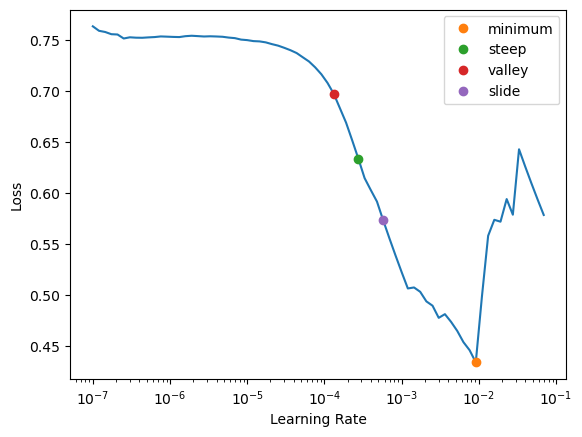

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.09536843746900558
valid_loss 0.058085355907678604
accuracy_multi 0.9864284992218018


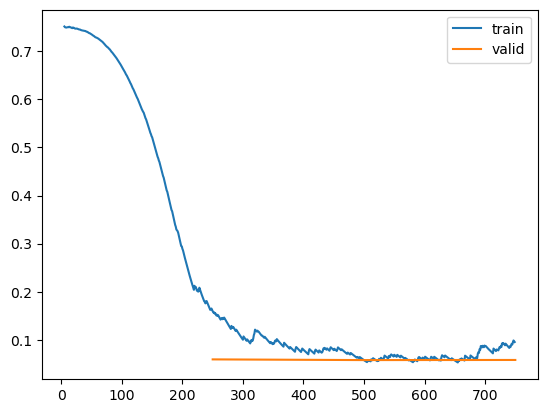

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,What if populism isn't the biggest menace? What if it's elitist arrogance and stupidity?,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",[]
1,"Comrade RTH, you mean the wall Trump promised he would make Mexico pay for? That wall?....lol....Dasvidaniya Comrade RTH #MRGA #itmfa...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",[]


In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([200, 7]), torch.Size([200, 7]), torch.Size([200]))

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Inference

We need to replace fastai's `Learner.predict` method with the one above which is able to work with inputs that are represented by multiple tensors included in a dictionary.

In [ ]:
# |export
@patch
def blurr_predict(self: Learner, items, rm_type_tfms=None, tok_is_split_into_words=False):
    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)
    batch_tok_tfm = get_blurr_tfm(self.dls.before_batch, tfm_class=BatchTokenizeTransform)
    item_tok_tfm = getattr(self.dls.dataset, "item_tokenize_transform", None)

    hf_tokenizer = tfm.hf_tokenizer
    trg_labels = tfm.kwargs["labels"] if ("labels" in tfm.kwargs) else None

    is_split_into_words = getattr(tfm, "is_split_into_words", tok_is_split_into_words)
    is_split_str = is_split_into_words == True and isinstance(items[0], str)
    is_df = isinstance(items, pd.DataFrame)

    if not is_df and (is_split_str or not is_listy(items)):
        items = [items]

    # we need to tokenize our items *if* we are not using the mid-level API batch-time tokenization
    if batch_tok_tfm is None and item_tok_tfm is None:
        inputs_d = dict(
            hf_tokenizer(
                items, is_split_into_words=is_split_into_words, padding=True, max_length=True, truncation=True, return_tensors="pt"
            )
        )
        items = [{k: inputs_d[k][idx] for k in inputs_d.keys()} for idx in range(len(inputs_d["input_ids"]))]

    dl = self.dls.test_dl(items, rm_type_tfms=rm_type_tfms, num_workers=0)

    with self.no_bar():
        probs, _, decoded_preds = self.get_preds(dl=dl, with_input=False, with_decoded=True)

    trg_tfms = self.dls.tfms[self.dls.n_inp :]

    outs = []
    is_multilabel = isinstance(self.loss_func, BCEWithLogitsLossFlat)
    probs, decoded_preds = L(probs), L(decoded_preds)
    for i in range(len(items)):
        item_probs = probs.itemgot(i)
        item_dec_preds = decoded_preds.itemgot(i)
        item_dec_labels = tuplify([tfm.decode(item_dec_preds[tfm_idx]) for tfm_idx, tfm in enumerate(trg_tfms)])[0]

        if trg_labels:
            # handle multiclass output
            if isinstance(item_dec_labels, str) or isinstance(item_dec_labels, int):
                item_dec_labels = [trg_labels[int(item_dec_labels)]]
            elif len(item_dec_labels.size()) == 0:
                item_dec_labels = [item_dec_labels.item()]
            # handle multilabel output
            else:
                item_dec_labels = [trg_labels[lbl_idx] for lbl_idx, lbl in enumerate(item_dec_labels) if lbl == True]

        res = {}
        if is_multilabel:
            res["labels"] = list(item_dec_labels)
            msk = item_dec_preds[0]
            res["scores"] = item_probs[0][msk].tolist()
            res["class_indices"] = [int(val) for val in item_dec_preds[0]]
        else:
            res["label"] = item_dec_labels[0]
            res["score"] = item_probs[0].tolist()[item_dec_preds[0]]
            res["class_index"] = item_dec_preds[0].item()

        if trg_labels is not None or hasattr(self.dls, "vocab"):
            res["class_labels"] = trg_labels if trg_labels else self.dls.vocab
        else:
            res["class_labels"] = None

        res["probs"] = item_probs[0].tolist()

        outs.append(res)
    return outs

In [ ]:
nbdev.show_doc(Learner.blurr_predict)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/training/core.py#L210){target="_blank" style="float:right; font-size:smaller"}

### Learner.blurr_predict

>      Learner.blurr_predict (items, rm_type_tfms=None,
>                             tok_is_split_into_words=False)

### Multiclass

In [ ]:
inf_learn = load_learner("../models/test_text_core_low_level.pkl")

In [ ]:
inf_learn.blurr_predict("This is perhaps the best movie I have ever seen!!!")

[{'label': 1,
  'score': 0.7868980169296265,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.21310196816921234, 0.7868980169296265]}]

In [ ]:
inf_learn.blurr_predict(["I really liked the movie", "Worse movie I ever saw"])

[{'label': 1,
  'score': 0.7883042693138123,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.21169576048851013, 0.7883042693138123]},
 {'label': 1,
  'score': 0.5577854514122009,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.4422145485877991, 0.5577854514122009]}]

In [ ]:
inf_learn = load_learner("../models/test_text_core_mid_level.pkl")

In [ ]:
inf_learn.blurr_predict("Acting was so bad it was almost funny.")

[{'label': '0',
  'score': 0.5704787373542786,
  'class_index': 0,
  'class_labels': [0, 1],
  'probs': [0.5704787373542786, 0.4295212924480438]}]

In [ ]:
inf_learn.blurr_predict(["I really liked the movie", "Worse movie I ever saw"])

[{'label': '1',
  'score': 0.842475950717926,
  'class_index': 1,
  'class_labels': [0, 1],
  'probs': [0.15752404928207397, 0.842475950717926]},
 {'label': '1',
  'score': 0.6181015968322754,
  'class_index': 1,
  'class_labels': [0, 1],
  'probs': [0.3818983733654022, 0.6181015968322754]}]

### Multilabel

In [ ]:
inf_learn = load_learner("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
inf_learn.blurr_predict("I will tell everyone what you did if you tell you jerk!")

[{'labels': [],
  'scores': [],
  'class_indices': [0, 0, 0, 0, 0, 0, 0],
  'class_labels': ['toxicity',
   'severe_toxicity',
   'obscene',
   'threat',
   'insult',
   'identity_attack',
   'sexual_explicit'],
  'probs': [0.050915904343128204,
   0.0013999355724081397,
   0.001687550568021834,
   0.0023364771623164415,
   0.03573402762413025,
   0.004955102223902941,
   0.0014892281033098698]}]

In [ ]:
inf_learn = load_learner("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
inf_learn.loss_func.thresh = 0.02


comment = """
Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes.
No enchiladas for them!
"""
inf_learn.blurr_predict(comment)

[{'labels': ['toxicity', 'insult'],
  'scores': [0.03964785113930702, 0.025824252516031265],
  'class_indices': [1, 0, 0, 0, 1, 0, 0],
  'class_labels': ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'],
  'probs': [0.03964785113930702,
   0.0008066092268563807,
   0.0009322299738414586,
   0.0018717617494985461,
   0.025824252516031265,
   0.003877515671774745,
   0.0008420744561590254]}]

In [ ]:
# |echo:false
try:
    del inf_learn
except:
    pass
finally:
    clean_memory()

## Text Generation

With regards to **text generation**, though not useful in sequence classification, we will also add a `blurr_generate` method to `Learner` that uses Hugging Face's `PreTrainedModel.generate` for text generation tasks.  

For the full list of arguments you can pass in see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate). You can also check out their ["How To Generate"](https://github.com/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb) notebook for more information about how it all works.

In [ ]:
# |export
@patch
def blurr_generate(self: Learner, items, key="generated_texts", **kwargs):
    """Uses the built-in `generate` method to generate the text
    (see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
    for a list of arguments you can pass in)
    """
    if not is_listy(items):
        items = [items]

    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)

    # grab the Hugging Face tokenizer from the learner's dls.tfms
    hf_tokenizer = tfm.hf_tokenizer
    tok_kwargs = tfm.tok_kwargs

    # grab the text generation kwargs
    text_gen_kwargs = tfm.text_gen_kwargs if (len(kwargs) == 0) else kwargs

    results = []
    for idx, inp in enumerate(items):
        if isinstance(inp, str):
            input_ids = hf_tokenizer.encode(inp, padding=True, truncation=True, return_tensors="pt", **tok_kwargs)
        else:
            # note (10/30/2020): as of pytorch 1.7, this has to be a plain ol tensor (not a subclass of TensorBase)
            input_ids = inp.as_subclass(Tensor)

        input_ids = input_ids.to(self.model.hf_model.device)

        gen_texts = self.model.hf_model.generate(input_ids, **text_gen_kwargs)
        outputs = [hf_tokenizer.decode(txt, skip_special_tokens=True, clean_up_tokenization_spaces=False) for txt in gen_texts]

        if tfm.hf_arch == "pegasus":
            outputs = [o.replace("<n>", " ") for o in outputs]

        results.append({key: outputs[0] if len(outputs) == 1 else outputs})

    return results

In [ ]:
nbdev.show_doc(Learner.blurr_generate)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/training/core.py#L283){target="_blank" style="float:right; font-size:smaller"}

### Learner.blurr_generate

>      Learner.blurr_generate (items, key='generated_texts', **kwargs)

Uses the built-in `generate` method to generate the text
(see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
for a list of arguments you can pass in)

## Tests

The tests below to ensure the core DataBlock code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

## Export -

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()